<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/MNIST_MetricLearning_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap-learn
!pip install pytorch-metric-learning
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=9c812deaea253c4bf3c3f66d0feff8547babff4ec6b04fadea43bed0a28a5174
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 45.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

train_dataset = torchvision.datasets.MNIST(root="data",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
valid_dataset = torchvision.datasets.MNIST(root="data",
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 94131909.76it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115808502.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31557509.84it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19399723.80it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
from pytorch_metric_learning import losses

In [4]:
class MyModel(nn.Module):
  def __init__(self, input_size):
    super(MyModel, self).__init__()
    self.size = input_size*input_size
    self.fc1 = nn.Linear(self.size, 1024)
    self.fc2 = nn.Linear(1024, 256)
  def forward(self, x):
    x = x.view(-1, self.size)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel(28).to(device)
model

MyModel(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
)

In [5]:
metric = losses.ArcFaceLoss(num_classes=10, embedding_size=256, scale=64, margin=32).to(device)
optimizer = torch.optim.Adam(
    [{'params': model.parameters()}, {'params': metric.parameters()}],
    lr=0.001)

In [6]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()

  tot_loss /= len(loader)
  return tot_loss

def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
  tot_loss /= len(loader)
  return tot_loss

In [7]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss = do_train(model, device, train_loader, metric, optimizer)
  valid_loss = do_valid(model, device, valid_loader, metric)
  print(f"--> train loss {train_loss}, valid loss {valid_loss}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 5.299542478645153, valid loss 2.7974150581685766
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 2.162879181287583, valid loss 2.257299005344049
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 1.5771699529224885, valid loss 1.7977026486144374
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 1.2764281940225197, valid loss 1.7921357204095272
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 1.0452420457010883, valid loss 1.8233904262958978
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.893748293210322, valid loss 1.4657182601842913
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.7842317127419052, valid loss 1.7618827926551073
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.7059195177104922, valid loss 1.4845532478480372
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.6307845236428543, valid loss 1.6153751127252598
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.5550507585505905, valid loss 1.5364030216977669


  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


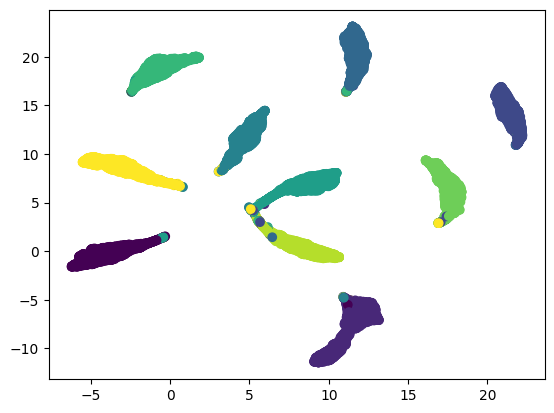

In [8]:
model.eval()

features = None
classes  = None

for images, labels in tqdm(valid_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
  # print(outputs.shape)
  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

import umap
umap = umap.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(features)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=classes)
plt.show()

In [9]:
from pytorch_metric_learning.distances import CosineSimilarity

# 最初のバッチについて特徴量を作成
images, labels = valid_loader.__iter__().__next__()

model.eval()
with torch.no_grad():
  images = images.to(device)
  features = model(images)

# 距離を計算
ret = CosineSimilarity()(features, features).cpu()

# 最初の文字とのコサイン距離が近いものを抽出する（閾値0.9）
print(f"label = {labels[0]}")
for i in range(64):
  if ret[0][i] > 0.9 :
    print("-"*40, end="")
  print(f"score = {float(ret[0][i]):.3f} label = {int(labels[i])}")

label = 7
----------------------------------------score = 1.000 label = 7
score = 0.008 label = 2
score = 0.021 label = 1
score = 0.019 label = 0
score = 0.009 label = 4
score = 0.024 label = 1
score = 0.002 label = 4
score = 0.000 label = 9
score = 0.000 label = 5
score = 0.000 label = 9
score = 0.019 label = 0
score = 0.084 label = 6
score = 0.000 label = 9
score = 0.102 label = 0
score = 0.016 label = 1
score = 0.028 label = 5
score = 0.000 label = 9
----------------------------------------score = 0.994 label = 7
score = 0.000 label = 3
score = 0.018 label = 4
score = 0.136 label = 9
score = 0.077 label = 6
score = 0.042 label = 6
score = 0.023 label = 5
score = 0.015 label = 4
score = 0.019 label = 0
----------------------------------------score = 0.980 label = 7
score = 0.016 label = 4
score = 0.038 label = 0
score = 0.054 label = 1
score = 0.000 label = 3
score = 0.064 label = 1
score = 0.000 label = 3
score = 0.023 label = 4
----------------------------------------score = 0.985 

# FAISS

In [10]:
import faiss
import random

In [11]:
dim = 256
nlist = 10
m = 32
nbits = 8

quantizer = faiss.IndexFlatIP(dim)

# index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_INNER_PRODUCT)
index = faiss.IndexIVFPQ(quantizer, dim, nlist, m, nbits, faiss.METRIC_INNER_PRODUCT)

In [21]:
# 訓練データの特徴量とラベルを全て抜き出す

model.eval()

features = None
classes  = None

for images, labels in tqdm(train_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    outputs = (outputs.transpose(1,0)/outputs.norm(dim=1)).transpose(1,0)

  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

  0%|          | 0/938 [00:00<?, ?it/s]

In [22]:
# 圧縮のために一部のデータで特徴量の分布を学習させる
train_data = np.array([v for v in  features if random.random() < 0.01])
index.train(train_data)

In [23]:
# 10000個毎に追加：細切れで追加可能なので、後から追加も可能
batch_size = 10000
for i in range(0, len(classes), batch_size):
  input_vecs = []
  input_ids = []
  for item_id, vec in zip(classes[i:i+batch_size], features[i:i+batch_size]):
    input_vecs.append(vec)
    input_ids.append(item_id)
  input_vecs = np.array(input_vecs, dtype=np.float32)
  input_ids = np.array(input_ids, dtype=np.int64)
  index.add_with_ids(input_vecs, input_ids)

# 作成したインデックスを保存
faiss.write_index(index, "features.index")

In [24]:
# インデックスを使って近傍検索を行う

# 検証データから最初の64個を取り出して特徴量を生成
images, labels = valid_loader.__iter__().__next__()
model.eval()
with torch.no_grad():
  images = images.to(device)
  features = model(images)
  features = (features.transpose(1,0)/features.norm(dim=1)).transpose(1,0)

# 保存したインデックスを読み込む
index = faiss.read_index("features.index")

D, I = index.search(features.cpu().numpy(), 3) # 近傍３個を取得（D: distance, I: index）

for label, idx, dist in zip(labels, I, D):
  print(f"正解={label}, 検索結果(上位3位) = {idx}, 距離={dist}")

正解=7, 検索結果(上位3位) = [7 7 7], 距離=[1.0117587 1.0112928 1.0111568]
正解=2, 検索結果(上位3位) = [2 2 2], 距離=[1.0044209 1.0029014 1.0022001]
正解=1, 検索結果(上位3位) = [1 1 1], 距離=[1.0106051 1.0101323 1.0098234]
正解=0, 検索結果(上位3位) = [0 0 0], 距離=[1.0036978 1.0030011 1.0029044]
正解=4, 検索結果(上位3位) = [4 4 4], 距離=[1.0104531 1.0089529 1.0057443]
正解=1, 検索結果(上位3位) = [1 1 1], 距離=[1.0096077 1.0069891 1.0068643]
正解=4, 検索結果(上位3位) = [4 4 4], 距離=[1.0055665 1.0049548 1.004778 ]
正解=9, 検索結果(上位3位) = [9 9 9], 距離=[0.9453857  0.93756396 0.9335641 ]
正解=5, 検索結果(上位3位) = [5 5 5], 距離=[0.6942986  0.6900421  0.68081045]
正解=9, 検索結果(上位3位) = [9 9 9], 距離=[1.0073209 1.0047226 1.0037606]
正解=0, 検索結果(上位3位) = [0 0 0], 距離=[0.9989075  0.99833107 0.99789304]
正解=6, 検索結果(上位3位) = [6 6 6], 距離=[1.0124125 1.0012308 0.9975149]
正解=9, 検索結果(上位3位) = [9 9 9], 距離=[1.0099766 1.0073568 1.0059943]
正解=0, 検索結果(上位3位) = [0 0 0], 距離=[1.0042915 1.0023911 1.0018886]
正解=1, 検索結果(上位3位) = [1 1 1], 距離=[1.0069267 1.0055128 1.0049037]
正解=5, 検索結果(上位3位) = [5 5 5], 距離=[0.9937055  0.9

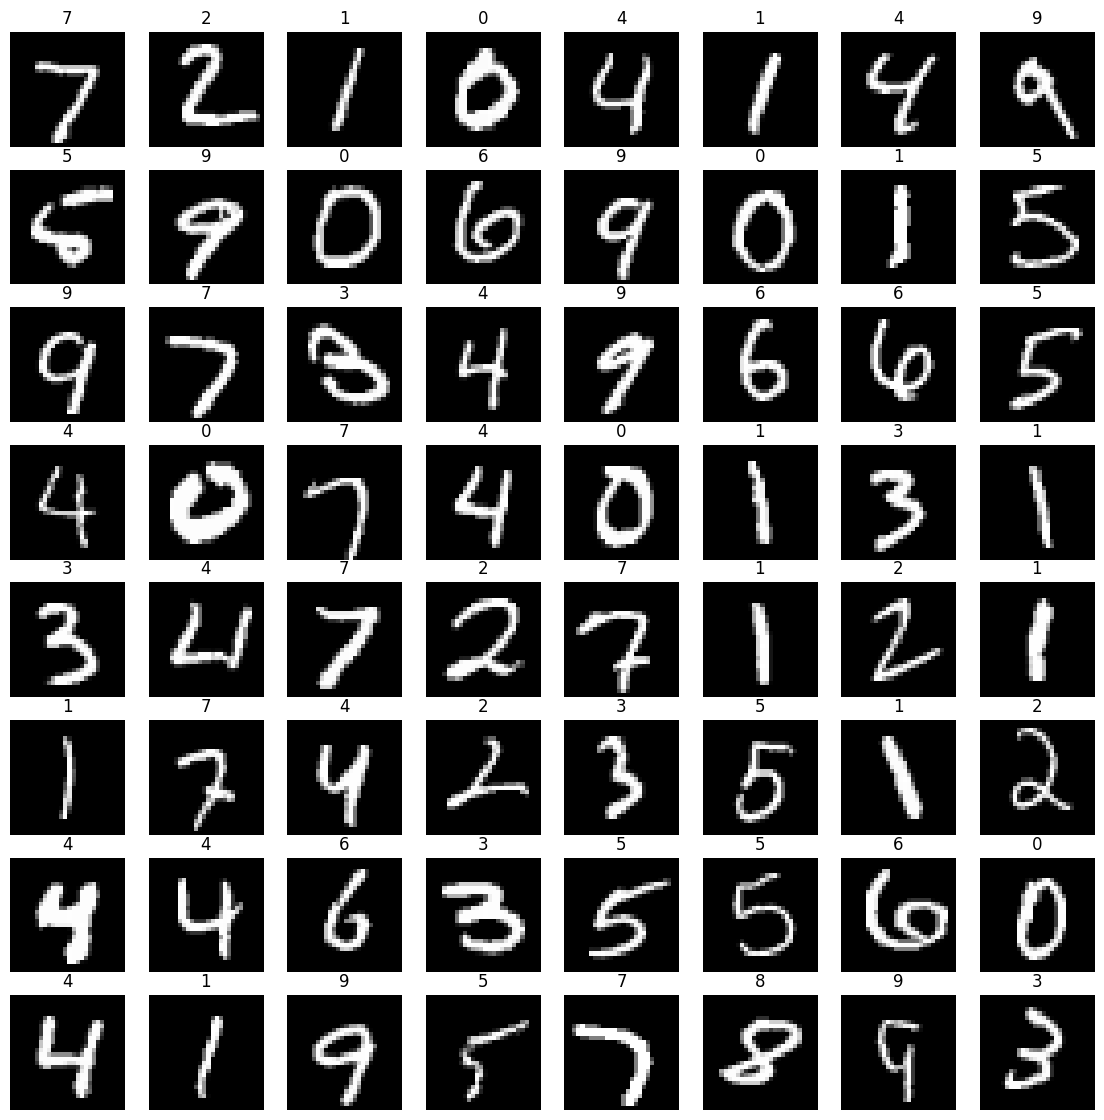

In [29]:
# データを確認
fig, ax = plt.subplots(8,8, figsize=(14,14))

for i, img in enumerate(images):
  label = int(labels[i])
  r, c = i//8, i%8
  ax[r, c].imshow(img.squeeze(), cmap="gray")
  ax[r, c].axis("off")
  ax[r, c].set_title(label)